## Introduction

In this notebook I am trying to implement negative prompts where given a text diffusion models try to generate an image but by passing a negative prompt it takes the text mention in negative prompt out of the diffused image.

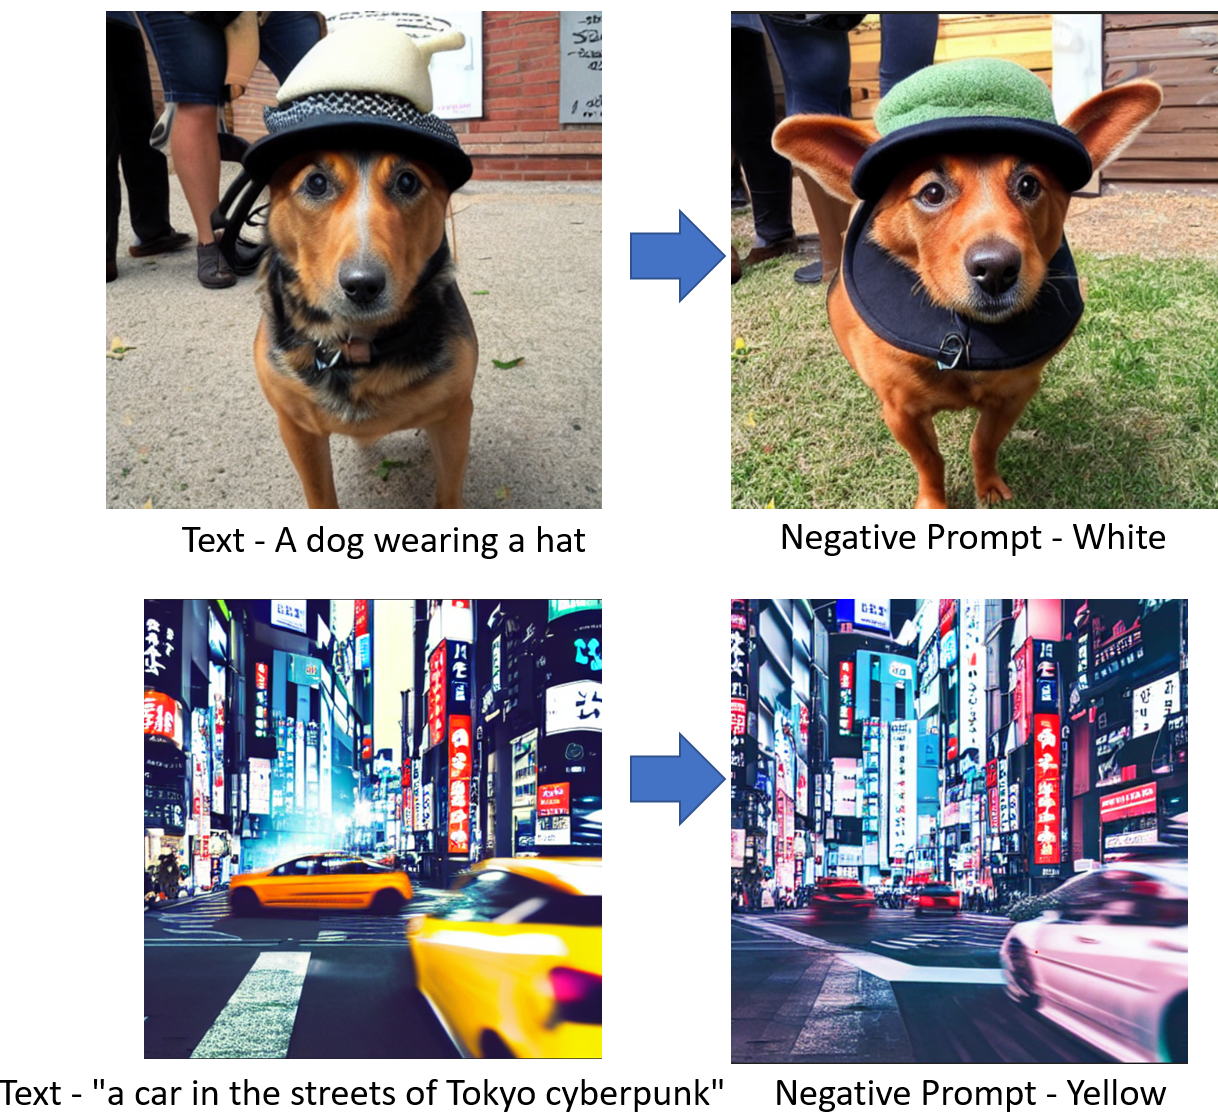

## Importing libraries

In [71]:
import torch, logging
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from diffusers import StableDiffusionPipeline
from PIL import Image
from pathlib import Path


from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()
logging.disable(logging.WARNING) ## ignore warnings
%matplotlib inline

## Pre loading models

Stable diffusion model depends on three things - 
1. `CLIP model` - For converting promts to a embedding which gives the visual clue
2. `VAE (Variational Auto Encoder)` - To reduce the dimensions of the original image for faster computations
3. `UNET` - The model which takes a noisy i/p and embedded promt to predict the noise present in the i/p

### Importing diffusion UNet and VAE

In [12]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

### CLIP artifacts

In this case, we are using CLIP model which converts the texual prompt into an embedding. To do this using transformers library ,we need two things - 
- 1) `Tokenizer` - This function takes the raw text, breaks it into words and then convert them into numeric forms
- 2) `text_encoder` - This function takes the tokenizer ip and convert them into embeddings

In [14]:
## Loading clip tokenizer and encoder 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

### Scheduler Artifacts

This tells the model on how much noise to add at a given timestep

In [27]:
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

Text(0.5, 1.0, 'Schedular routine')

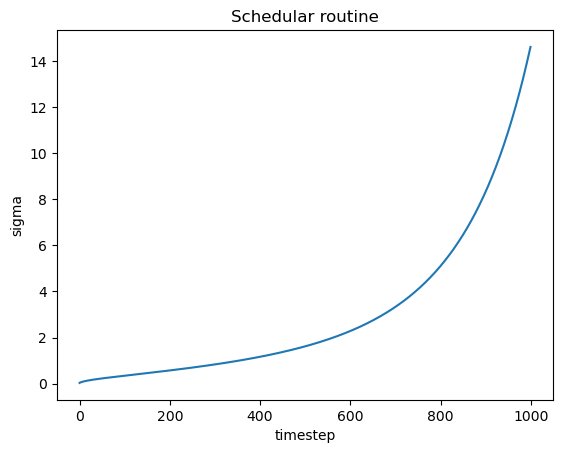

In [46]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1])
plt.xlabel("timestep")
plt.ylabel("sigma")
plt.title("Schedular routine")

## Simple text to image inference

In [47]:
def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    """
    A function to take the sample and convert it back into the original image
    """
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [112]:
def mk_samples_neg_prompt(prompts, neg_prompt=None, g=7.5, seed=100, steps=70, dim=512):
    """
    
    """
    bs = len(prompts)
    text = text_enc(prompts) 
    if not neg_prompt:
        uncond =  text_enc([""] * bs, text.shape[1])
    else:
        assert len(prompts) == len(neg_prompt)
        uncond =  text_enc(neg_prompt, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

  0%|          | 0/70 [00:00<?, ?it/s]

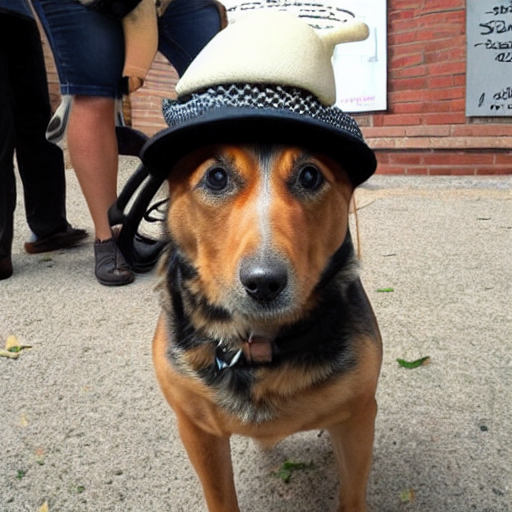

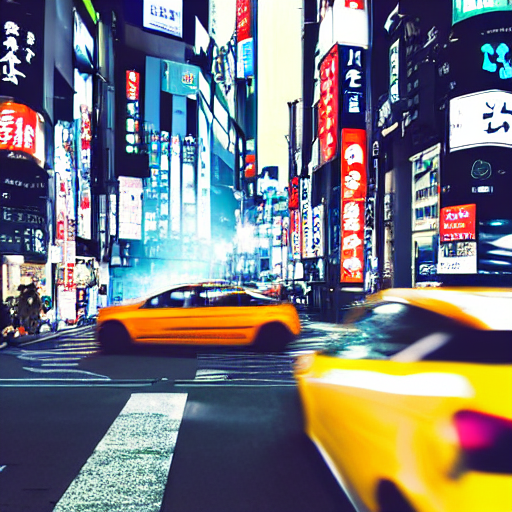

In [114]:
prompts = ["A dog wearing a hat", "a car in the streets of Tokyo cyberpunk"]
torch.manual_seed(2000)
images = mk_samples_neg_prompt(prompts)
for img in images:display(mk_img(img))

  0%|          | 0/70 [00:00<?, ?it/s]

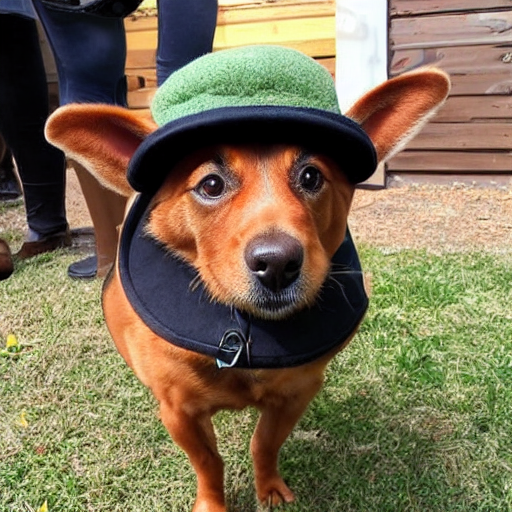

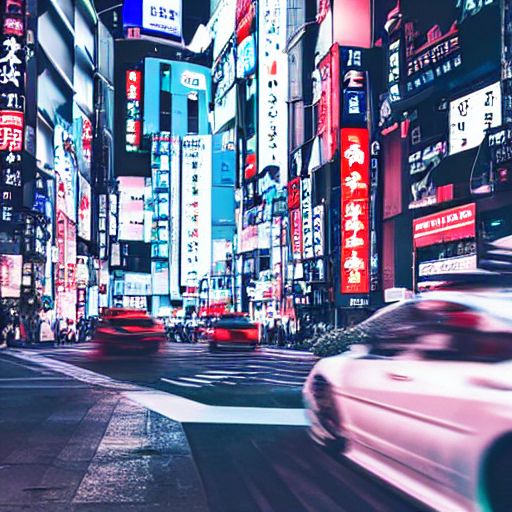

In [115]:
neg_prompts = ["white", "yellow"]
torch.manual_seed(2000)
images = mk_samples_neg_prompt(prompts, neg_prompts)
for img in images:display(mk_img(img))